In [109]:
from dataclasses import dataclass
import numpy as np
import jax
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx
import matplotlib.pyplot as plt

In [110]:
@dataclass
class Data():
    pass

In [111]:
def create_uniform_nodes(N_intervals):
    x_nodes = jnp.linspace(0.0, 1.0, N_intervals+1)
    return x_nodes

In [112]:
def mesh_points(gauss_point: jnp.ndarray, index: int):
    N_cell = gauss_point.shape[0] - 1     # N centres -> N cellules
    x_center = create_uniform_nodes(N_cell)
    dx = 1.0 / N_cell                  # taille d'une cellule uniforme
    xL = x_center[1:] - 0.5 * dx
    xR = x_center[:-1] + 0.5 * dx
    return xL, xR

In [113]:
x_gauss = jnp.linspace(0, 1, 11)
N_cell = len(x_gauss) - 1
print("Gauss points:", x_gauss)
xL, xR = mesh_points(x_gauss, 1)
print("Left mesh points:", xL)
print("Right mesh points:", xR)

Gauss points: [0.         0.1        0.2        0.3        0.4        0.5
 0.6        0.7        0.8        0.90000004 1.        ]
Left mesh points: [0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95]
Right mesh points: [0.05       0.15       0.25       0.35000002 0.45000002 0.55
 0.65000004 0.75       0.85       0.95000005]


In [114]:
mesh_points_result = mesh_points(x_gauss, jnp.arange(1, N_cell))
print("Left mesh points:", mesh_points_result[0])
print("Right mesh points:", mesh_points_result[1])

Left mesh points: [0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95]
Right mesh points: [0.05       0.15       0.25       0.35000002 0.45000002 0.55
 0.65000004 0.75       0.85       0.95000005]


In [115]:
def phi(x, x_nodes, i):
    x_i = x_nodes[i]

    # voisin gauche : existe seulement si i > 0
    left = jnp.where(
        (i > 0) & (x >= x_nodes[i-1]) & (x <= x_i),
        (x - x_nodes[i-1]) / (x_i - x_nodes[i-1]),
        0.0
    )

    # voisin droit : existe seulement si i < N-1
    right = jnp.where(
        (i < x_nodes.size - 1) & (x > x_i) & (x <= x_nodes[i+1]),
        (x_nodes[i+1] - x) / (x_nodes[i+1] - x_i),
        0.0
    )

    return left + right

# vectorisation sur i
vmap_phi = jax.vmap(phi, in_axes=(None, None, 0))

In [116]:
N = 5
x_nodes = jnp.linspace(0, 1, N)
x = 0.4

values = vmap_phi(x, x_nodes, jnp.arange(N))
print(values)

[0.         0.39999998 0.6        0.         0.        ]


x_nodes: [0.         0.1        0.2        0.3        0.4        0.5
 0.6        0.7        0.8        0.90000004 1.        ]


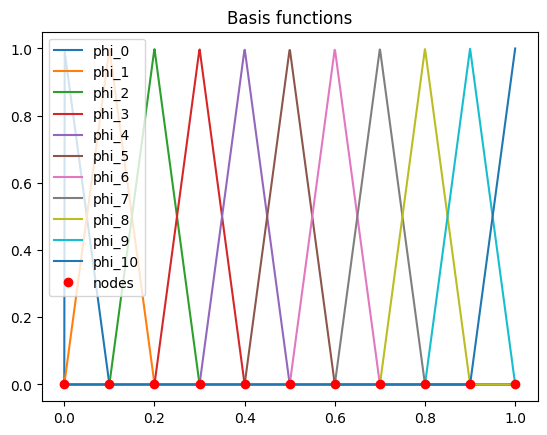

In [117]:
x=jnp.linspace(0, 1, 1000)
x_nodes = jnp.linspace(0, 1, 11)
print("x_nodes:", x_nodes)
index = jnp.arange(0, x_nodes.size)
phi_values = vmap_phi(x, x_nodes, index)
plt.plot(x, phi_values.T,label=[f"phi_{i}" for i in range(x_nodes.size)])
plt.plot(x_nodes, jnp.zeros_like(x_nodes), 'ro', label="nodes")
plt.title("Basis functions")
plt.legend()
plt.show()

In [118]:
def Mass_Matrix(x_nodes, n_quad=1000):
    N_nodes = x_nodes.size

    # Integration méthode des trapèzes
    xq = jnp.linspace(0.0, 1.0, n_quad)
    dxq = xq[1] - xq[0]
    w = jnp.ones(n_quad) * dxq
    w = w.at[0].set(dxq / 2.0)
    w = w.at[-1].set(dxq / 2.0)

    phi_vals = vmap_phi(xq, x_nodes, jnp.arange(N_nodes))

    #M_ij = sum_k w_k * phi_i(x_k) * phi_j(x_k)
    M = phi_vals @ (phi_vals * w).T

    return M

M = Mass_Matrix(x_nodes)
print(M.shape)
print("Mass Matrix:\n", M)

(11, 11)
Mass Matrix:
 [[0.0328345  0.01666545 0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.01666545 0.06666821 0.01666625 0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.         0.01666625 0.06666682 0.01666685 0.         0.
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.01666685 0.0666658  0.01666725 0.
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.01666725 0.06666518 0.01666745
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.01666745 0.06666504
  0.01666745 0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.01666745
  0.06666522 0.01666724 0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.01666724 0.06666581 0.01666685 0.         0.        ]
 [0.     

In [119]:
def Flux_Function(u,index):
    uL = u[index]
    uR = u[index + 1]
    phi_L= phi

In [ ]:
def volume_func(u,j,dt):
    mesh_points = create_uniform_nodes(100)
    u_n = u(mesh_points)
    # phi evaluated at mesh points (for diagnostics) - phi expects scalar x -> returns scalar
    scalar_phi = lambda x: phi(x, x_nodes, j)
    phi_of_x = scalar_phi(mesh_points)
    # compute d/dx phi at each mesh point: vectorize the scalar gradient
    dphi_of_x_dx = jax.vmap(jax.grad(scalar_phi))(mesh_points)

    #Flux = Flux_Function(u_n,j)
    Flux=0.
    return jnp.sum(u_n * phi_of_x - dt*Flux * dphi_of_x_dx)

vmap_volume_func = jax.vmap(volume_func, in_axes=(None, 0, None))


In [125]:
#fonction erreur
def error_L2(u_pred: jnp.ndarray, u_true: jnp.ndarray):
    return jnp.sqrt(jnp.sum((u_pred - u_true)**2) / u_true.shape[0])


In [126]:
f = lambda x: jnp.sin(2 * jnp.pi * x)*jnp.exp(-5 * x)

N = 100
index = jnp.arange(N)
print("index:", index)
dx = 1.0 / N

x_centers = (index) * dx       # centres réels des volumes
x_nodes   = jnp.linspace(0, 1, N+1)  # nœuds FEM

u = f

u_volume = vmap_volume_func(u, index, 0.01)
print("u shape:", u.shape)
print("u_volume shape:", u_volume.shape)
print(u_volume[0:5], u[0:5])
print("u_volume shape:", u_volume.shape)


index: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]


TypeError: Expected a callable value, got VmapTracer<float32[101]>

L2 error: 0.0023440942


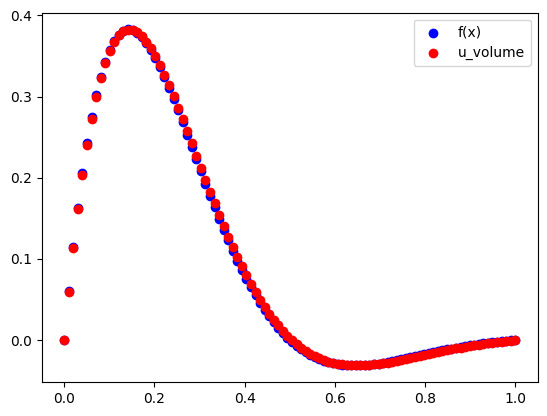

In [ ]:
# Visualisation
x_test = jnp.linspace(0, 1, 100)
print("L2 error:", error_L2(u_volume, f(x_test)))
plt.scatter(x_test, f(x_test), color='blue', label='f(x)')
plt.scatter(x_test, u_volume, color='red', label='u_volume')
plt.legend()
